In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import cv2
import PIL
import PIL.Image
import matplotlib.pyplot as plt


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#TODO: This dataset is actually RAF-DB insteal of AffectNet!!!
train_path = '/content/drive/My Drive/CS6476/RAFDB/DATASET/train'
val_path = '/content/drive/My Drive/CS6476/RAFDB/DATASET/val'
test_path = '/content/drive/My Drive/CS6476/RAFDB/DATASET/test'

In [ ]:
# preprocess training data using ImageDataGenerator
# note: we can use mobilenet.preprocess_input because the start of patt-lite is a truncated mobilenet!
train_data = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=64,
    color_mode='rgb',
    class_mode='categorical'
    )

val_data = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=64,color_mode='rgb',class_mode='categorical')

test_data = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=64,color_mode='rgb',class_mode='categorical',
    shuffle=False
)

Found 9814 images belonging to 7 classes.
Found 2457 images belonging to 7 classes.
Found 3068 images belonging to 7 classes.


In [ ]:
# load patt-lite model
model = keras.models.load_model('/content/drive/My Drive/CS6476/patt-lite.h5')

In [ ]:
# unfreeze all parameters
model.trainable = True

In [ ]:
# learning rate scheduler
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# train model on train_data for 20 epochs
history = model.fit(train_data, epochs=20, validation_data=val_data, callbacks=[reduce_lr_callback])

Epoch 1/20
154/154 [==============================] - 1532s 10s/step - loss: 1.2212 - accuracy: 0.6213 - val_loss: 3.9418 - val_accuracy: 0.2055 - lr: 0.0010
Epoch 2/20
154/154 [==============================] - 1574s 10s/step - loss: 0.7908 - accuracy: 0.7304 - val_loss: 1.8095 - val_accuracy: 0.2287 - lr: 0.0010
Epoch 3/20
154/154 [==============================] - 1583s 10s/step - loss: 0.5952 - accuracy: 0.8019 - val_loss: 2.3221 - val_accuracy: 0.2316 - lr: 0.0010
Epoch 4/20
154/154 [==============================] - ETA: 0s - loss: 0.4828 - accuracy: 0.8394
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
154/154 [==============================] - 1528s 10s/step - loss: 0.4828 - accuracy: 0.8394 - val_loss: 2.3309 - val_accuracy: 0.2072 - lr: 0.0010
Epoch 5/20
154/154 [==============================] - 1583s 10s/step - loss: 0.2606 - accuracy: 0.9198 - val_loss: 0.7445 - val_accuracy: 0.7574 - lr: 1.0000e-04
Epoch 6/20
154/154 [========================

In [ ]:
# already saved!
# model.save('/content/drive/MyDrive/CS6476/training_1/patt-lite-retrained.keras')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/CS6476/training_1/patt-lite-retrained.keras')

In [ ]:
# test accuracy on test_data
test_loss, test_acc = model.evaluate(test_data)
print('Test accuracy:', test_acc)

48/48 [==============================] - 1092s 23s/step - loss: 0.1433 - accuracy: 0.9658
Test accuracy: 0.965775728225708


Inference Time

In [ ]:
batch_size = 64

In [ ]:
# test inference time
import time
start = time.time()
model.predict(test_data)
end = time.time()
print('Average inference time:', (end - start)/(len(test_data)*batch_size))

48/48 [==============================] - 127s 3s/step
Average inference time: 0.04632780266304811


In [ ]:
baseline_model = keras.models.load_model(('/content/drive/MyDrive/CS6476/training_1/MobileNet-epoch20-batch64.keras'))

In [ ]:
start = time.time()
baseline_model.predict(test_data)
end = time.time()
print('Average inference time:', (end - start)/(len(test_data)*batch_size))

48/48 [==============================] - 138s 3s/step
Average inference time: 0.044951815934230886


Accuracy & Loss

In [ ]:
# extract training and validation accuracy from history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
# extract training and validation loss from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

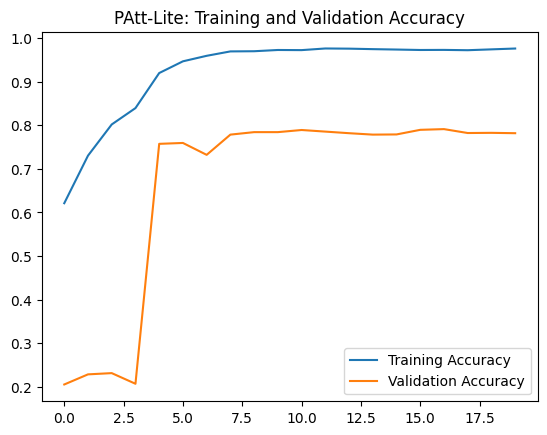

In [ ]:
# plot training and accuracy validation
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('PAtt-Lite: Training and Validation Accuracy')
plt.legend()
plt.show()

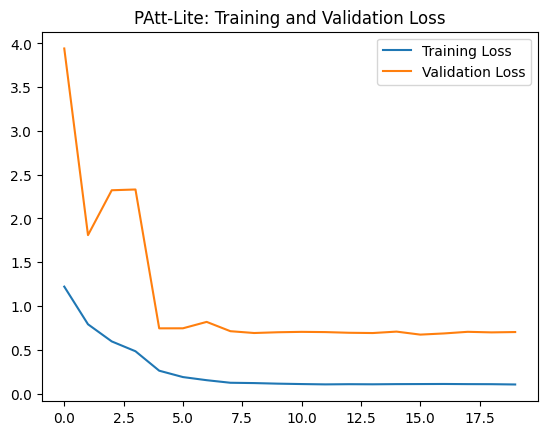

In [ ]:
# plot training and validation losses
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('PAtt-Lite: Training and Validation Loss')
plt.legend()
plt.show()